'''
 *--------------------------------------------------------------------------
 *--------------------------------------------------------------------------
 *
 * Copyright (C) 2017 Kareem Abdelfatah - krabea@email.sc.edu
 *
 * The main applications of the StackedGP framework are to integrate different datasets through model composition, 
 * enhance predictions of quantities of interest through a cascade of intermediate predictions, and
 * to propagate uncertainties through emulated dynamical systems driven by uncertain forcing variables. 
 * By using analytical first and second-order moments of a Gaussian process as presented in the 
 * following paper:
 * 
 * Kareem Abdelfatah, Junshu Bao, Gabriel Terejanu (2017). 
 Environmental Modeling Framework using Stacked Gaussian Processes. arXiv:1612.02897v2 . 18 Jun 2017
 * 
 * This program is free software; you can redistribute it and/or modify
 * it under the terms of the GNU General Public License as published by
 * the Free Software Foundation; either version 2 of the License, or
 * (at your option) any later version.
 *
 * This program is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU General Public License for more details.
 *
 * You should have received a copy of the GNU General Public License along
 * with this program; if not, write to the author.
 *
 *--------------------------------------------------------------------------
 *
 * cadmium_prediction_StackedGPStackedGP(Co_Cr).ipynb
 * 
 *--------------------------------------------------------------------------
 *-------------------------------------------------------------------------- 
 '''

### This File used to predict cadmium using the following stacked structure
    ## First layer: has two nodes
        # input is location,Ni,Zn
        # output is Co,Cr
    ## Second layer:
        # input is location, Ni, Zn, Co, Cr
        # output is Cd


In [1]:
%matplotlib inline 

import sys
sys.path.append('../')
sys.path.append('../../stackedgp_src/')
from __future__ import division
from mpl_toolkits.mplot3d import axes3d
from stackedGPNetwork import StackedGPNetwork
from sklearn.cross_validation import KFold
import GPy, time
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA

## Load Data

In [2]:
X = np.genfromtxt('../data/jura2.csv', delimiter=',')[:,[0,1]] # x,y locations
Y = np.genfromtxt('../data/jura2.csv', delimiter=',')[:,[4,10,8]] # Cd, Zn, Ni
Co_Cr = np.genfromtxt('../data/jura2.csv', delimiter=',')[:,[5,6]] # 5 is the index of Co
# X = np.concatenate((X,Y[:,1:]),axis=1) # add Zn, Ni to the input matrix

Cd = Y[:,0:1]
Zn_Ni = Y[:,1:]

print 'Min of Cd: ', Cd.min(axis=0)
Co_Cr[:,1:] = np.log(Co_Cr[:,1:]+1)
# Co_Cr = np.log(Co_Cr+1)
Cd = np.log(Cd)
if Co_Cr.shape[1] > 1:
    ica = FastICA(n_components=Co_Cr.shape[1],random_state=100,fun='exp')
    Co_Cr[:259,:] = ica.fit_transform(Co_Cr[:259,:])
    Co_Cr[259:,:] = ica.transform(Co_Cr[259:,:])
    
scaler = StandardScaler()
scaler1 = StandardScaler()
scaler2 = StandardScaler()
Cd[:259,:] = scaler.fit_transform(Cd[:259,:])
Co_Cr[:259,:] = scaler1.fit_transform(Co_Cr[:259,:])

Zn_Ni[:259,:] = scaler2.fit_transform(Zn_Ni[:259,:])
Zn_Ni[259:,:] = scaler2.transform(Zn_Ni[259:,:])
print 'normalisation: mean/std',scaler.mean_,scaler.std_

Min of Cd:  [ 0.135]
normalisation: mean/std [ 0.03607936] [ 0.70738224]


 /usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning:internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.


## Train Stacked GP

In [3]:
# ntrain = X.shape[0]
trainX,testX = X[:259,:], X[259:,:]
train_Cd, test_Cd = Cd[:259,:], Cd[259:,:]
train_Zn_Ni, test_Zn_Ni = Zn_Ni[:259,:],Zn_Ni[259:,:]
train_Co_Cr, test_Co_Cr = Co_Cr[:259,:], Co_Cr[259:,:]
# testY = scaler.inverse_transform(testY)
test_Cd = np.exp(test_Cd)
print trainX.shape

(259, 2)


In [4]:
stackedNetwork = StackedGPNetwork(3)

# train the first layer: Two GPs--> Zn, Ni
no_GPs = Zn_Ni.shape[1]
for i in range(no_GPs):
    stackedNetwork.createNewNode(0,X,Zn_Ni[:,i:i+1], normalize=True, ARD = False, useGPU=False)
#     stackedNetwork.getNode(0,-1).likelihood.variance.fix(1e-5)

# train the second layer: two GPs--> Co, Cr
trainX_Zn_Ni = np.concatenate((trainX,train_Zn_Ni),axis=1)
no_GPs = train_Co_Cr.shape[1]
for i in range(no_GPs):
    stackedNetwork.createNewNode(1,trainX_Zn_Ni,train_Co_Cr[:,i:i+1], normalize=True, ARD = False, useGPU=False)

# train the third layer:One GP --> Cd
traindata = np.concatenate((trainX_Zn_Ni,train_Co_Cr), axis=1)
stackedNetwork.createNewNode(2,traindata,train_Cd, normalize=True, ARD=False, useGPU=False)


t0= time.clock()
stackedNetwork.optimize(numoptimizationtrails=1)
t= time.clock() - t0 # t is CPU seconds elapsed (floating point)
print 'Training Time = ',t

Training Time =  1.432394


## Test Stacked GP on Testing

In [5]:
# predict from the first layer,
#create the input data for the first layer
finput_mean = np.tile(testX,Zn_Ni.shape[1])
fout_mean, fout_var = stackedNetwork.predictLayer(0,finput_mean,None,include_likelihood=False, covoption=2)

# predict from the second layer,
#create the input data for the second layer
sinput_mean = np.concatenate((testX,fout_mean),axis=1)
sinput_var = np.concatenate((np.zeros(testX.shape),fout_var),axis=1)
sinput_mean_lay = np.tile(sinput_mean,no_GPs)
sinput_var_lay = sinput_var #np.tile(sinput_var,no_GPs)
sout_mean, sout_var = stackedNetwork.predictLayer(1,sinput_mean_lay,sinput_var_lay,jitter=0, covoption=3,include_likelihood=True)

# predict from the third layer,
tinput_mean = np.concatenate((sinput_mean,sout_mean),axis=1)
tinput_var = np.concatenate((sinput_var,sout_var),axis=1)
mean, var = stackedNetwork.predictLayer(2,tinput_mean,tinput_var, jitter=0, covoption=2, include_likelihood=True,include_covnoise=True)

E_af = scaler.inverse_transform(mean)
E_af = np.exp(E_af)

In [6]:
#=========================================================================
#=========================================================================
print 'Applying log-normal distribution inverse...'
varun = var
print 'Mean (min/max): ',E_af.min(), E_af.max()
rmse = np.sqrt(np.sum(np.square(E_af-test_Cd))/test_Cd.shape[0])
print 'RMSE: ', rmse
mae = np.sum(abs(E_af-test_Cd))/test_Cd.shape[0]
print 'MAE: ', mae
pstd = np.sqrt(varun)
print 'Predicted STD: ', pstd.min(), pstd.max()

Applying log-normal distribution inverse...
Mean (min/max):  0.381170162899 1.94669746355
RMSE:  0.545588420735
MAE:  0.380723254256
Predicted STD:  0.619058762098 0.909419136283


In [7]:
# Heatmaps for grids testX_locations
# ttx = testX[np.lexsort((testX[:,0],testX[:,1])),:]
x = np.linspace(int(X[:,0].min())+1, int(X[:,0].max()), 100)
y = np.linspace(int(X[:,1].min())+1, int(X[:,1].max()), 100)
locX,locY = np.meshgrid(x, y)
# ttx = testX
# locX,locY = np.meshgrid(ttx[:,0],ttx[:,1])
LOC = np.concatenate((locX.flatten().reshape(-1,1),locY.flatten().reshape(-1,1)),axis=1)
hm_Zn = []
hm_Ni = []
hm_Co = []
hm_Cr = []
hm_Cd = []
step = 200
for i in range(0,LOC.shape[0],step):
    loc = LOC[i:i+step,:]
    print i,
#     print "Locations: ",loc.shape
    # predict from the first layer,
    #create the input data for the first layer

    finput_mean = np.tile(loc,Zn_Ni.shape[1])
    fout_mean, fout_var = stackedNetwork.predictLayer(0,finput_mean,None,include_likelihood=False)
    hm_Zn+= list(fout_mean[:,0])
    hm_Ni+= list(fout_mean[:,1])
#     print "fout_mean max: ",fout_mean.shape, fout_mean.max()
    # predict from the second layer,
    #create the input data for the second layer
    
    sinput_mean = np.concatenate((loc,fout_mean),axis=1)
    sinput_var = np.concatenate((np.zeros(loc.shape),fout_var),axis=1)
    sinput_mean_lay = np.tile(sinput_mean,no_GPs)
    sinput_var_lay = sinput_var #np.tile(sinput_var,no_GPs)
    sout_mean, sout_var = stackedNetwork.predictLayer(1,sinput_mean_lay,sinput_var_lay,include_likelihood=True)
    hm_Co+= list(sout_mean[:,0])
    hm_Cr+= list(sout_mean[:,1])

#     print "sout_mean max: ",sout_mean.shape, sout_mean.max()

    # predict from the third layer,
    
    tinput_mean = np.concatenate((sinput_mean,sout_mean),axis=1)
    tinput_var = np.concatenate((sinput_var,sout_var),axis=1)
    mean, var = stackedNetwork.predictLayer(2,tinput_mean,tinput_var, jitter=0, covoption=1, include_likelihood=True,include_covnoise=True)
    hm_Cd+= list(mean[:,0])

0 200 400 600 800 1000 1200 1400 1600 1800 2000 2200 2400 2600 2800 3000 3200 3400 3600 3800 4000 4200 4400 4600 4800 5000 5200 5400 5600 5800 6000 6200 6400 6600 6800 7000 7200 7400 7600 7800 8000 8200 8400 8600 8800 9000 9200 9400 9600 9800


In [8]:
len(hm_Zn)

10000

In [9]:
hm_Zn1 = np.array(hm_Zn).reshape(-1,1)
hm_Ni1 = np.array(hm_Ni).reshape(-1,1)
hm_Co1 = np.array(hm_Co).reshape(-1,1)
hm_Cr1 = np.array(hm_Cr).reshape(-1,1)
hm_Cd1 = np.array(hm_Cd).reshape(-1,1)

hm_Zn_Ni = np.concatenate((hm_Zn1,hm_Ni1),axis=1)
hm_Zn_Ni =  scaler2.inverse_transform(hm_Zn_Ni)
hm_Zn1 = hm_Zn_Ni[:,0].reshape(locX.shape)
hm_Ni1 = hm_Zn_Ni[:,1].reshape(locX.shape)

hm_Co_Cr = np.concatenate((hm_Co1,hm_Cr1),axis=1)
hm_Co_Cr =  scaler1.inverse_transform(hm_Co_Cr)
hm_Co_Cr = ica.inverse_transform(hm_Co_Cr)
hm_Co1 = hm_Co_Cr[:,0].reshape(locX.shape)
hm_Cr1 = np.exp(hm_Co_Cr[:,1]).reshape(locX.shape)
# hm_Co1 = np.exp(hm_Co_Cr[:,0]).reshape(locX.shape)


E_af = scaler.inverse_transform(hm_Cd1)
hm_Cd1 = np.exp(E_af).reshape(locX.shape)


In [10]:
# data = pd.DataFrame(data=hm_Zn1, index=locX[0,:], columns=locY[:,0])
# loc_pd = pd.DataFrame(data=X, columns=['X','Y'])
# loc_pd
# hm_Zn1.shape 

In [23]:
def heatmap1(z,title_label):
    x = locX.ravel()
    y = locY.ravel()
#     z = hm_Zn1.ravel()
    plt.hexbin(x, y, C=z, gridsize=70, cmap=plt.cm.jet, bins=None)
    plt.axis([x.min(), x.max(), y.min(), y.max()])
    cb = plt.colorbar()
    cb.set_label('mean value')
    plt.title(title_label)
    plt.scatter(x=trainX[:,0], y=trainX[:,1],marker='+' )
    plt.savefig("_".join(title_label)+"1.png")

def heatmap2(z,title_label):
    fig = plt.figure(figsize=(5,5),facecolor='w') 
    ax = fig.add_subplot(111)
    plt.title(title_label)
    ax = sns.heatmap(z, xticklabels=False, yticklabels=False, cmap=plt.cm.jet,ax=ax)
    ax.set_xlabel("X locations")
    ax.set_ylabel("Y locations")
    plt.savefig("_".join(title_label)+"2.png")

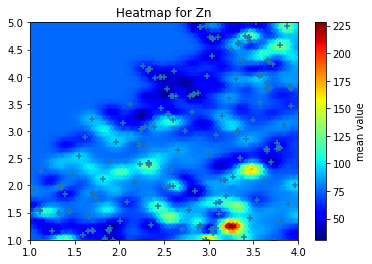

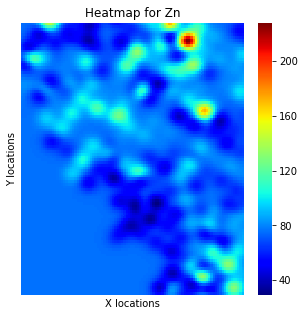

In [24]:
# fig = plt.figure(figsize=(5,5),facecolor='w') 
# ax = fig.add_subplot(111)
# plt.title("Heatmap for Zn")
# sns.set_style("ticks")
# ax = sns.heatmap(hm_Zn1, xticklabels=False, yticklabels=False, cmap="YlGnBu",ax=ax)
# ax.imshow(hm_Zn1,cmap="YlGnBu")
# ax.scatter(x=X[:,0], y=X[:,1],marker='+' )
# ax = sns.lmplot('X','Y',data=loc_pd,fit_reg=False)
# sns.heatmap(data, xticklabels=1, yticklabels=1, cmap="YlGnBu",ax=ax)
# plt.xticks(np.arange(min(X[:,0]), max(X[:,0])+1, 1.0))
# ax.set_xlabel("X locations")
# ax.set_ylabel("Y locations")
# plt.savefig("Zn.png")
heatmap1(hm_Zn1.ravel(),'Heatmap for Zn')
heatmap2(hm_Zn1,'Heatmap for Zn')

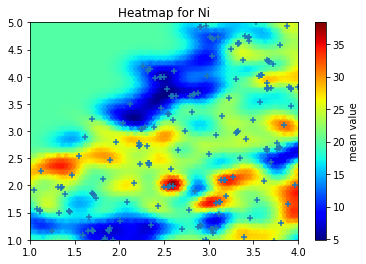

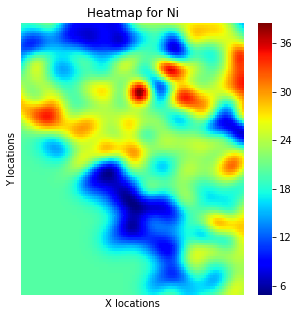

In [25]:
# fig = plt.figure(figsize=(5,5),facecolor='w') 
# ax = fig.add_subplot(111)
# plt.title("Heatmap for Ni")
# ax = sns.heatmap(hm_Ni1, xticklabels=False, yticklabels=False, cmap="YlGnBu",ax=ax)
# ax.set_xlabel("X locations")
# ax.set_ylabel("Y locations")
# plt.savefig("Ni.png")

heatmap1(hm_Ni1.ravel(),'Heatmap for Ni')
heatmap2(hm_Ni1,'Heatmap for Ni')

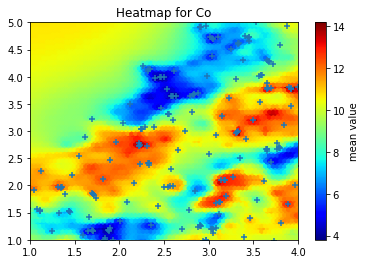

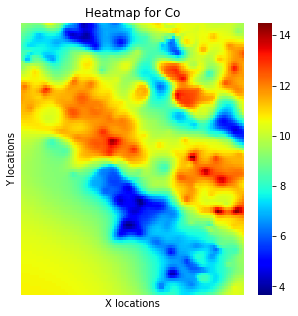

In [26]:
# fig = plt.figure(figsize=(5,5),facecolor='w') 
# ax = fig.add_subplot(111)
# plt.title("Heatmap for Co")
# ax = sns.heatmap(hm_Co1, xticklabels=False, yticklabels=False, cmap=plt.cm.jet,ax=ax)
# ax.set_xlabel("X locations")
# ax.set_ylabel("Y locations")
# plt.savefig("Co.png")
heatmap1(hm_Co1.ravel(),'Heatmap for Co')
heatmap2(hm_Co1,'Heatmap for Co')

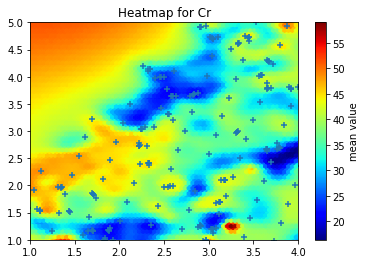

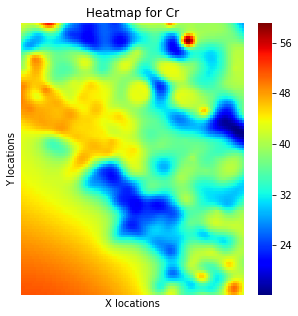

In [27]:
# fig = plt.figure(figsize=(5,5),facecolor='w') 
# ax = fig.add_subplot(111)
# plt.title("Heatmap for Cr")
# ax = sns.heatmap(hm_Cr1, xticklabels=False, yticklabels=False, cmap="YlGnBu",ax=ax)
# ax.set_xlabel("X locations")
# ax.set_ylabel("Y locations")
# plt.savefig("Cr.png")
heatmap1(hm_Cr1.ravel(),'Heatmap for Cr')
heatmap2(hm_Cr1,'Heatmap for Cr')

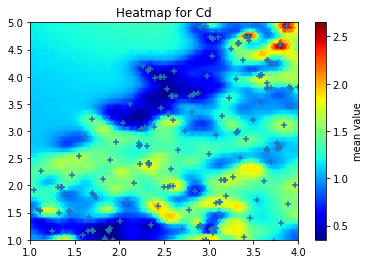

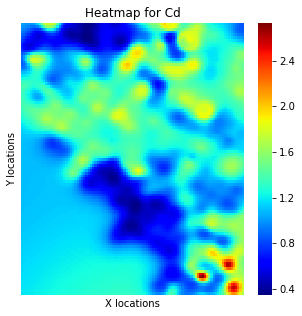

In [28]:
# fig = plt.figure(figsize=(5,5),facecolor='w') 
# ax = fig.add_subplot(111)
# plt.title("Heatmap for Cd")
# ax = sns.heatmap(hm_Cd1, xticklabels=False, yticklabels=False, cmap="YlGnBu",ax=ax)
# ax.set_xlabel("X locations")
# ax.set_ylabel("Y locations")
# plt.savefig("Cd.png")
heatmap1(hm_Cd1.ravel(),'Heatmap for Cd')
heatmap2(hm_Cd1,'Heatmap for Cd')